# EDA and comparison of the development of three Machine Learning models

In this notebook is the main analysis regarding the Tabular Playground Series of August with the aim of predicting the failure probability of products related to lab measures and conditions.

For the beginning, the main libraries are exported, related to the plotting features and the following 3 models that were tested:

- XGboost with the tool XGBClassifier
- Logistic Regression from Sklearn
- Simple neural network from Tensorflow

This was accomplished by comparing the accuracy with a validation set.

# Libraries and tools

This first cell shows the main libraries divided by methods and a general overview of the data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
#Pipeline
from sklearn.pipeline import make_pipeline
#Standard scaler
from sklearn.preprocessing import StandardScaler
#Train - Test split
from sklearn.model_selection import train_test_split
#GridSearch tool
from sklearn.model_selection import GridSearchCV
#Main models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
#Seeding for replication
np.random.seed(1)
tf.random.set_seed(156) #1 ya usado
#Initial Files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


# Data Analysis

Firstly, the train data was loaded to see initial null values and their types

In [2]:
train=pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/train.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

The initial data shows that most of the columns have null values. To complement this the first 5 rows of information are shown in the next cell

In [4]:
train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


As a way of being able to use all data the missing information was filled with the mean of the column, checking that 16 columns have at least 1 missing value

In [5]:
#Checking if there are columns with complete values in train dataset
no_null_cols=[]
for i in train.columns:
    if train[i].isna().value_counts()[0]-len(train[i])<0:
        no_null_cols.append(i)
print("Columns with missing data: ",len(no_null_cols))

Columns with missing data:  16


In [6]:
#Updating the missing data
for col in no_null_cols:
    null_cols=train[train[col].isna()].index
    for n in null_cols:
        train.loc[n,col]=train[col].mean()

Simultaneously, the object columns were transformed to category as a way of working with the models

In [7]:
Categories=[]
for i in train.columns:
    if train[i].dtype=="object":
        Categories.append(i)

In [8]:
for t in Categories:
    train[t]=train[t].astype("category")

With these changes, the resulting dataframe is presented

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              26570 non-null  int64   
 1   product_code    26570 non-null  category
 2   loading         26570 non-null  float64 
 3   attribute_0     26570 non-null  category
 4   attribute_1     26570 non-null  category
 5   attribute_2     26570 non-null  int64   
 6   attribute_3     26570 non-null  int64   
 7   measurement_0   26570 non-null  int64   
 8   measurement_1   26570 non-null  int64   
 9   measurement_2   26570 non-null  int64   
 10  measurement_3   26570 non-null  float64 
 11  measurement_4   26570 non-null  float64 
 12  measurement_5   26570 non-null  float64 
 13  measurement_6   26570 non-null  float64 
 14  measurement_7   26570 non-null  float64 
 15  measurement_8   26570 non-null  float64 
 16  measurement_9   26570 non-null  float64 
 17  measurement_

## EDA

To see the relation of the failure rate to the other columns firstly a histogram is presented to see the information distribution

<AxesSubplot:xlabel='failure', ylabel='Count'>

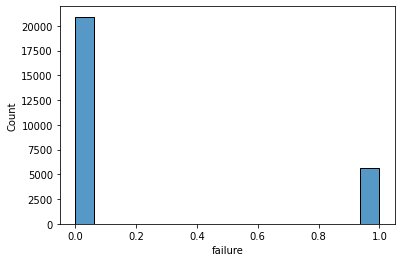

In [10]:
# failure histogram
sns.histplot(data=train,x="failure")

Most of the data correspond to products that didn't fail during the laboratory test. With this in consideration, the following figures show the boxplots between the failure and the rest of the variables, excluding the ID.

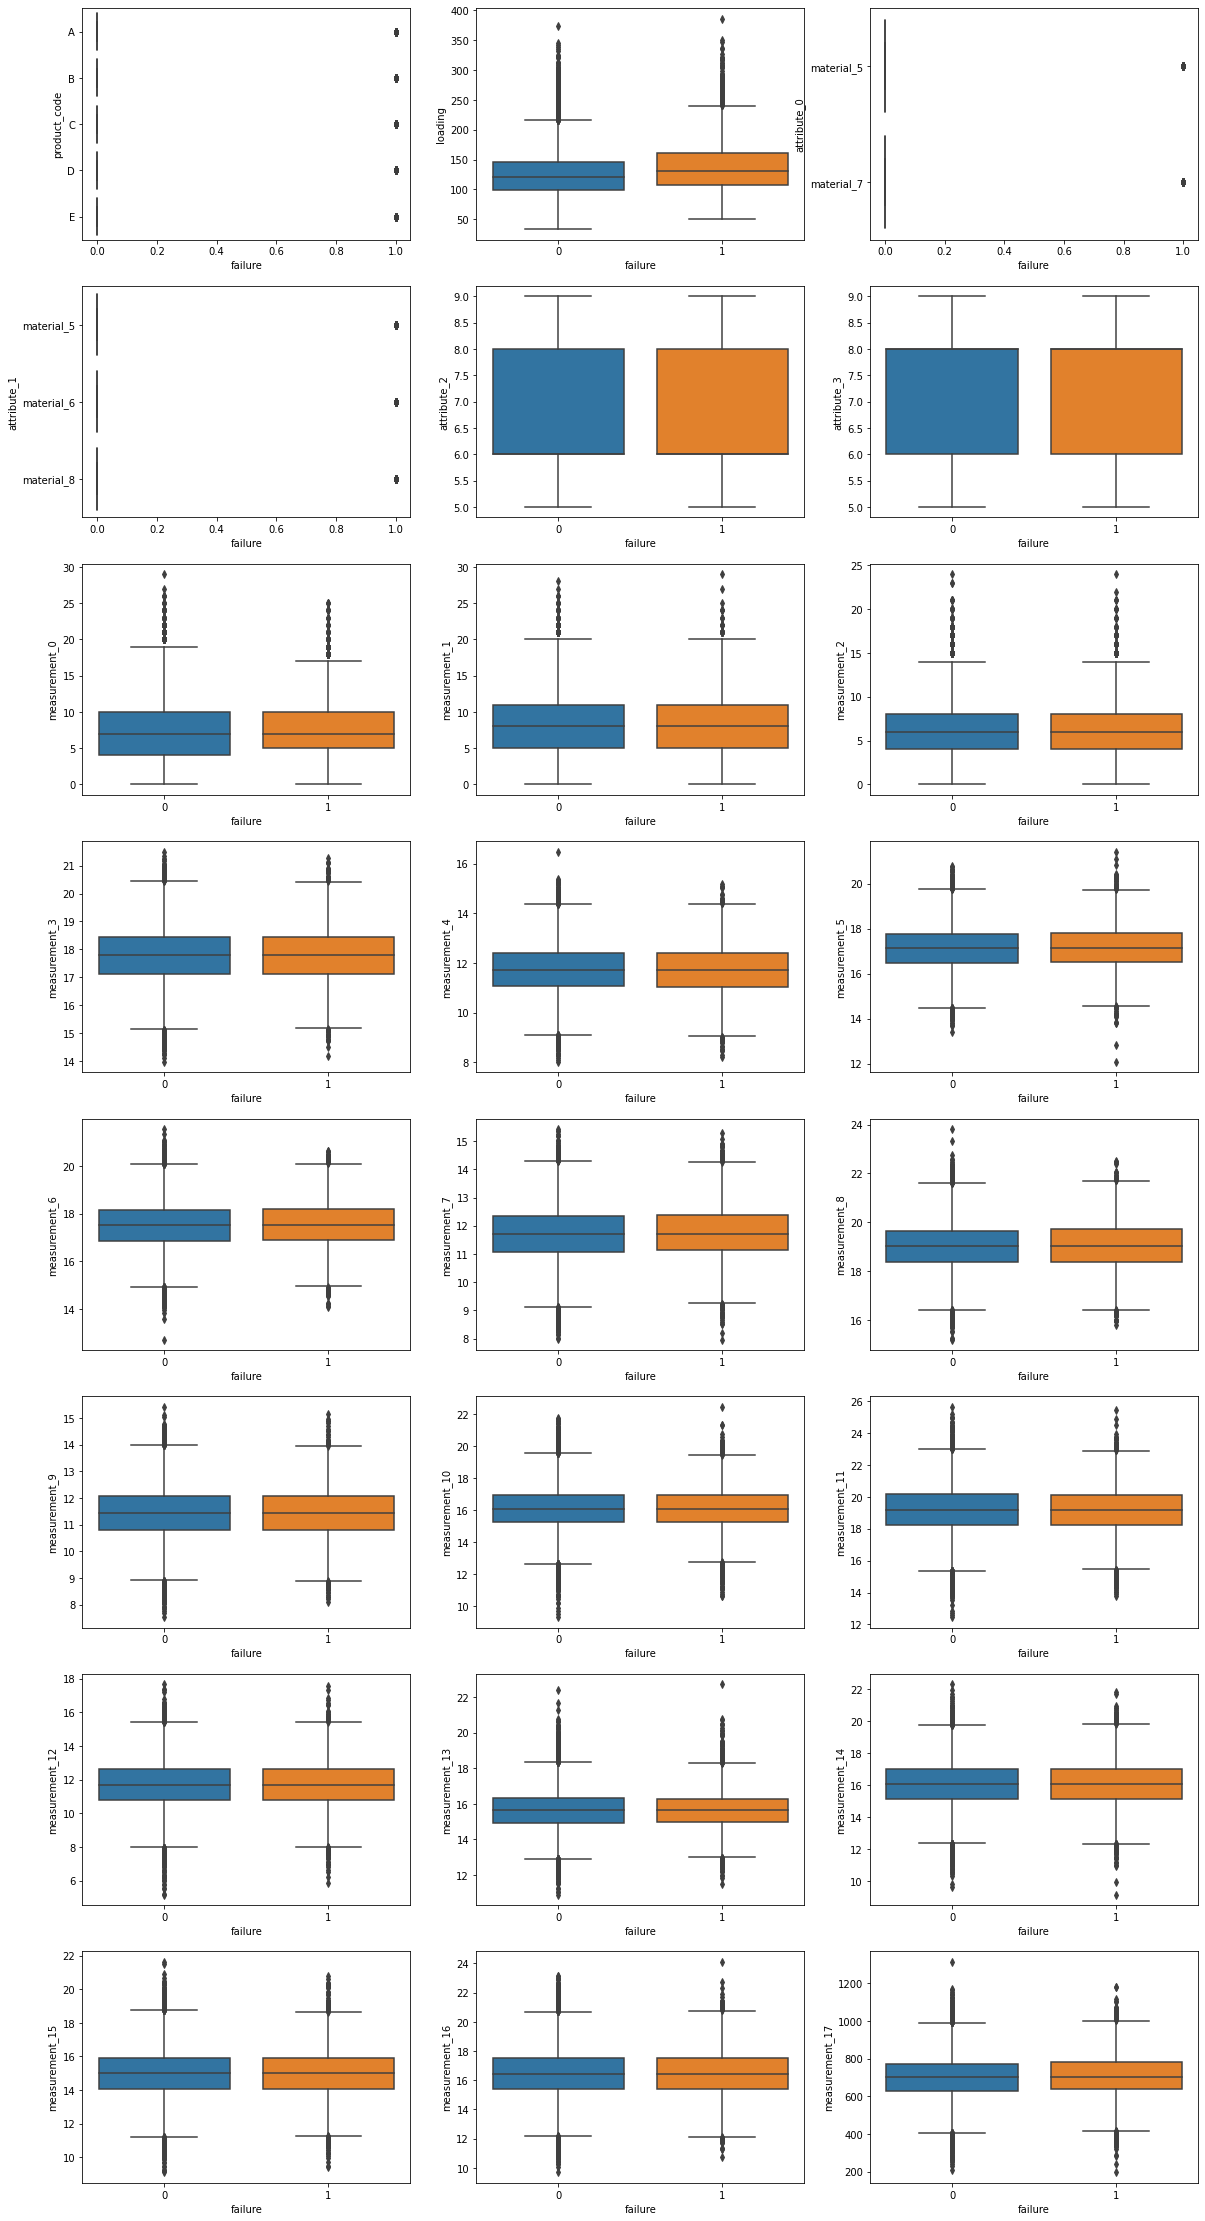

In [11]:
# Difference between variables and failure
plt.figure(figsize=(20,40))
# Count for subplot
n=1
for i in train.columns:
    if i != 'id' and i != 'failure':
        plt.subplot(8,3,n)
        sns.boxplot(data=train, x="failure", y=i)
        n=n+1

As it is presented there is no evident difference between most of the measurements regarding Failure, except for loading while the categorical values show that indeed the Failure could be related to outliers.

Then, to complement this data an additional correlation heat map was made to eliminate the values that could harm the modeling behavior

<AxesSubplot:>

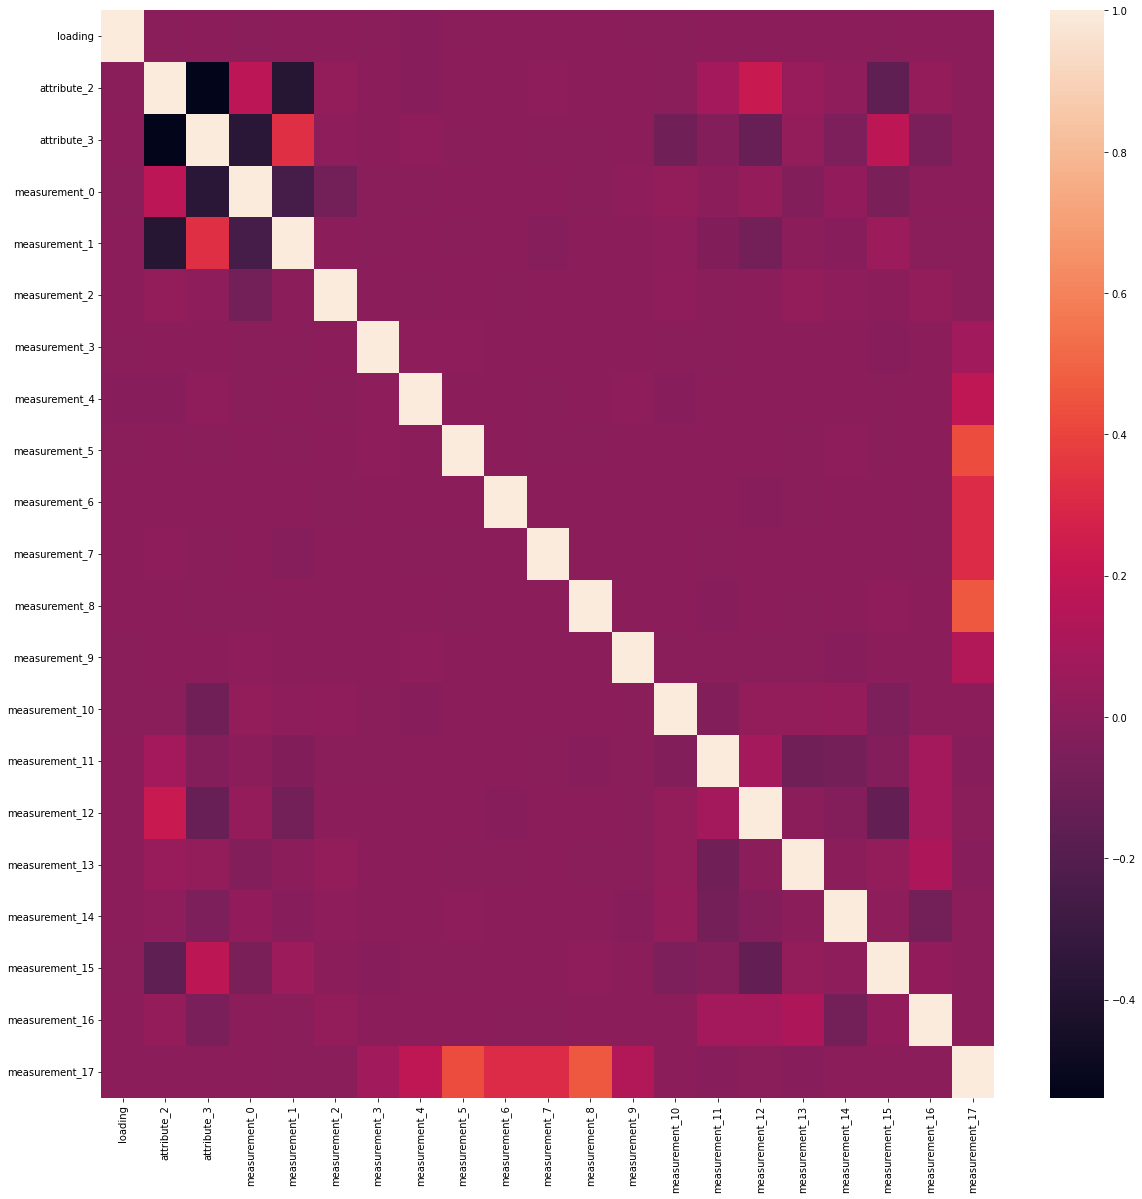

In [12]:
plt.figure(figsize=(20,20))
sns.heatmap(train[train.columns[1:-1]].corr())

Then, the following columns were erased from the total_cols list that contained all the columns' names

In [13]:
total_cols=list(train.columns)
#Removing columns - strings
total_cols.remove("id")
total_cols.remove("product_code")
total_cols.remove("attribute_0")
total_cols.remove("attribute_1")
total_cols.remove("attribute_2")
total_cols.remove("attribute_3")
total_cols.remove("measurement_0")
total_cols.remove("measurement_1")

In [14]:
total_cols

['loading',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17',
 'failure']

# Modeling testing

To begin with the analysis the train data was transformed to one-hot encoding and then with the resulting data frame, the information was split into train and test sets, with the use of `shuffle=False` to be able to replicate the same result.

In [15]:
#Data transformation
train_dum=pd.get_dummies(train[total_cols[:-1]],drop_first=True)

In [16]:
#Train - test split
x_train,x_test, y_train, y_test=train_test_split(train_dum,train["failure"],
                                                 test_size=0.3, shuffle=False)

## XGBoost

With the tool of XGBClassifier, the ratio of failure was predicted, comparing the train and test accuracy

In [17]:
#Training with 0.7 of total data
model = make_pipeline(StandardScaler(),XGBClassifier(max_depth=50,
                                                    n_estimators=100
                                                    ,n_jobs=-1),verbose=True).fit(x_train,y_train)

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing xgbclassifier, total=  11.2s


In [18]:
model.score(x_train,y_train)

1.0

In [19]:
model.score(x_test,y_test)

0.7775686864885208

As expected, with the train slice the model predicted all the data while on the validation set this value was reduced to the 77%

## Logistic regression and Cross-Validation test

With the same approach and pipeline, a simple Logistic Regression model was implemented, with a significant lower execution time that the XGBoost approach

In [20]:
model2 = make_pipeline(StandardScaler(),LogisticRegression(),verbose=True).fit(x_train,y_train)

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.0s


In [21]:
model2.score(x_train,y_train)

0.7871390934996505

In [22]:
model2.score(x_test,y_test)

0.7867268849579726

The test score is worse than in the previous case, but at the same time, the validation value is higher. In this case, this means that it would be the one that will predict better foreign data.

Then a simple cross-validation was made to check the effects of the penalty parameters of L2 and "none" to see if there is an improvement

In [23]:
#Type of penalty
penalty=[ "l2", "none"]

In [24]:
parameters=[{'penalty':penalty}]
Grid1 = GridSearchCV(LogisticRegression(max_iter=1000), parameters,cv=20)

In [25]:
Grid1.fit(x_train,y_train)

GridSearchCV(cv=20, estimator=LogisticRegression(max_iter=1000),
             param_grid=[{'penalty': ['l2', 'none']}])

In [26]:
Grid1.best_estimator_

LogisticRegression(max_iter=1000)

With this estimator the training was repeated, obtaining almost the same validation accuracy:

In [27]:
model3 = make_pipeline(Grid1.best_estimator_,verbose=True).fit(x_train,y_train)

[Pipeline]  (step 1 of 1) Processing logisticregression, total=   0.2s


In [28]:
model3.score(x_train,y_train)

0.7871390934996505

In [29]:
model3.score(x_test,y_test)

0.7869777945050809

## Tensorflow and Keras

Finally, a simple neural network was implemented. In this case, a simple model with Keras was made with 3 Dense layers and 2 dropout layers.

In [30]:
#Simple Neural Network
model4 =   tf.keras.Sequential([
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50, activation="relu", bias_regularizer='l2'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

2022-08-27 02:03:05.321430: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [31]:
#Model compilation 
model4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model4.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

2022-08-27 02:03:05.504298: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
582/582 [==============================] - 3s 3ms/step - loss: 4.7173 - accuracy: 0.6714 - val_loss: 0.5337 - val_accuracy: 0.7867
Epoch 2/10
582/582 [==============================] - 1s 3ms/step - loss: 0.6488 - accuracy: 0.7428 - val_loss: 0.5336 - val_accuracy: 0.7870
Epoch 3/10
582/582 [==============================] - 2s 3ms/step - loss: 0.5520 - accuracy: 0.7762 - val_loss: 0.5253 - val_accuracy: 0.7872
Epoch 4/10
582/582 [==============================] - 2s 3ms/step - loss: 0.5348 - accuracy: 0.7832 - val_loss: 0.5259 - val_accuracy: 0.7872
Epoch 5/10
582/582 [==============================] - 1s 2ms/step - loss: 0.5245 - accuracy: 0.7851 - val_loss: 0.5176 - val_accuracy: 0.7872
Epoch 6/10
582/582 [==============================] - 1s 3ms/step - loss: 0.5206 - accuracy: 0.7864 - val_loss: 0.5194 - val_accuracy: 0.7872
Epoch 7/10
582/582 [==============================] - 1s 3ms/step - loss: 0.5178 - accuracy: 0.7873 - val_loss: 0.5122 - val_accuracy: 0.7872
Epoch 

This model obtained the best accuracy value. For this reason the neural network model was used, but with all the available data.

---------

# Final Prediction

Firstly, the neural network model was trained with all the data to get the best results


In [32]:
#Model compilation 
model4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model4.fit(train_dum,train["failure"],epochs=10)

Epoch 1/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5145 - accuracy: 0.7874
Epoch 2/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5145 - accuracy: 0.7874
Epoch 3/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5132 - accuracy: 0.7874
Epoch 4/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5138 - accuracy: 0.7874
Epoch 5/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5135 - accuracy: 0.7874
Epoch 6/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5135 - accuracy: 0.7874
Epoch 7/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5126 - accuracy: 0.7874
Epoch 8/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5130 - accuracy: 0.7874
Epoch 9/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5140 - accuracy: 0.7874
Epoch 10/10
831/831 [==============================] - 2s 2ms/step - loss: 0.5135 - accuracy: 0.7874

Then, the test dataset was loaded, replacing the missing values with the mean of the columns as in the train dataframe

In [33]:
test=pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/test.csv")

In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20775 entries, 0 to 20774
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20775 non-null  int64  
 1   product_code    20775 non-null  object 
 2   loading         20552 non-null  float64
 3   attribute_0     20775 non-null  object 
 4   attribute_1     20775 non-null  object 
 5   attribute_2     20775 non-null  int64  
 6   attribute_3     20775 non-null  int64  
 7   measurement_0   20775 non-null  int64  
 8   measurement_1   20775 non-null  int64  
 9   measurement_2   20775 non-null  int64  
 10  measurement_3   20446 non-null  float64
 11  measurement_4   20366 non-null  float64
 12  measurement_5   20267 non-null  float64
 13  measurement_6   20151 non-null  float64
 14  measurement_7   20055 non-null  float64
 15  measurement_8   19929 non-null  float64
 16  measurement_9   19871 non-null  float64
 17  measurement_10  19708 non-null 

In [35]:
#Changing object columns to categories
Categories=[]
for i in test.columns:
    if test[i].dtype=="object":
        Categories.append(i)
for t in Categories:
    test[t]=test[t].astype("category")

In [36]:
#Replacing missing values
no_null_cols=[]
for i in test.columns:
    if test[i].isna().value_counts()[0]-len(test[i])<0:
        no_null_cols.append(i)
for col in no_null_cols:
    null_cols=test[test[col].isna()].index
    for n in null_cols:
        test.loc[n,col]=test[col].mean()

In [37]:
#One-hot encoding
test_dum=pd.get_dummies(test[total_cols[:-1]],drop_first=True)

In the end, the failure rates were predicted and presented in a boxplot before the final submission .csv saving

In [38]:
y_fin=list(model4.predict(test_dum))
#Example
y_fin[:5]

[array([0.18423173], dtype=float32),
 array([0.17460576], dtype=float32),
 array([0.18085206], dtype=float32),
 array([0.18952462], dtype=float32),
 array([0.24358654], dtype=float32)]

<AxesSubplot:>

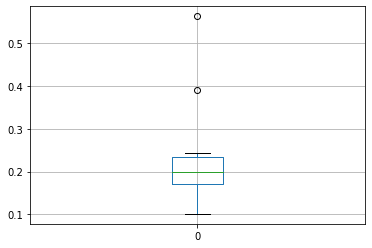

In [39]:
#Final boxplot
y=pd.DataFrame(y_fin)
y.boxplot()

In [40]:
#Final changes
test["failure"]=y_fin
test["failure"]=test["failure"].astype("float64")
Final_prediction=test[["id","failure"]]
#CSV
Final_prediction.to_csv("submission.csv",index=False)

# Final remarks

The chosen model was able to predict the ratio of failure of the test data, with the final values being between 0 and 0.5.